# Imports

We are importing the nessesary libraries. We are using GPU acceleration where we can with nvidia cuda and cudnn thats why we need specific verison of python and the libraries.

In [1]:
# Ensure TensorFlow 2.10 and all required libraries are installed before running the code 
# !pip install tensorflow==2.10.0 keras==2.10.0 numpy==1.24.3 scikeras==0.4.1 pandas==1.5.3 matplotlib==3.7.5 opencv-python==4.8.1.78 Pillow==9.5.0 scikit-learn==1.1.3 tqdm==4.66.1 imagehash==4.3.2 psutil scikit-learn-intelex==2023.2.1

In [2]:
from sklearnex import patch_sklearn # optimized version of sklearn for Intel Processors, it has to be imported before any other sklearn import
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import random
from PIL import Image
import time
import psutil
from tqdm import tqdm
import imagehash
import matplotlib.pyplot as plt
from collections import defaultdict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scikeras.wrappers import KerasClassifier 


c:\Users\Marci\.conda\envs\ml_gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.10.0
Num GPUs Available: 1


# Helper functions

These are for tracking GPU, CPU and memory utiilization

In [5]:
# Define image dimensions
IMG_HEIGHT = 256 
IMG_WIDTH = 256
CHANNELS = 3 

# Define batch size for tf.data
BATCH_SIZE = 64 

# Configure TensorFlow GPU options
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [6]:

def get_cpu_ram_usage():

    process = psutil.Process(os.getpid())
    try:
        cpu_percent = psutil.cpu_percent(interval=0.1)
    except Exception as e:
        print(f"Could not get CPU percentage: {e}")
        cpu_percent = -1 

    mem_info = process.memory_info()
    print("Attributes available on mem_info object:")
    print(dir(mem_info))
    print("mem_info object:", mem_info)

    try:
        ram_usage = mem_info.rss / (1024 * 1024)
        return cpu_percent, ram_usage
    except AttributeError:
        print("AttributeError: 'rss' not found.")
        return cpu_percent, -1

def get_gpu_memory_usage():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            gpu_status = tf.config.experimental.get_memory_info('GPU:0')
            return gpu_status['current'] / (1024 * 1024) 
        except Exception as e:
            print(f"Could not retrieve detailed GPU memory info: {e}")
            return -1
    return 0

def record_cpu_ram_usage(resource_dict):
    cpu, ram = get_cpu_ram_usage()
    resource_dict['cpu_percent'].append(cpu)
    resource_dict['ram_usage_mb'].append(ram)

# Data Loading

We open the xmls, and making a joining dataframes

In [7]:
DATA_ROOT_DIR = 'data_final'

In [8]:

def parse_annotations_from_dir(root_folder):
    all_xml_paths = []
    image_base_paths = {}


    print(f"Collecting XML file paths from {root_folder}...")
    for country_folder in os.listdir(root_folder):
        country_path = os.path.join(root_folder, country_folder)
        annotations_path = os.path.join(country_path, 'annotations')
        images_path = os.path.join(country_path, 'images')

        if os.path.isdir(annotations_path) and os.path.isdir(images_path):
            country_xml_files = [os.path.join(annotations_path, f) for f in os.listdir(annotations_path) if f.endswith('.xml')]
            all_xml_paths.extend(country_xml_files)

            if country_folder not in image_base_paths:
                 image_base_paths[country_folder] = images_path

            annotation_dir_to_image_dir[annotations_path] = images_path


    print(f"Found {len(all_xml_paths)} XML files.")
    records = []
    error_files = [] 

    print("Starting XML file parsing...")
    with tqdm(total=len(all_xml_paths), desc="Parsing XML files") as pbar:
        for xml_file_path in all_xml_paths:
            try:
                tree = ET.parse(xml_file_path)
                root = tree.getroot()

                filename_elem = root.find('filename')
                filename = filename_elem.text if filename_elem is not None else None

                size = root.find('size')
                width_elem = size.find('width') if size is not None else None
                height_elem = size.find('height') if size is not None else None
                depth_elem = size.find('depth') if size is not None else None

                width = int(width_elem.text) if width_elem is not None and width_elem.text else None
                height = int(height_elem.text) if height_elem is not None and height_elem.text else None
                depth = int(depth_elem.text) if depth_elem is not None and depth_elem.text else None

                xml_dir = os.path.dirname(xml_file_path)

                corresponding_image_dir = annotation_dir_to_image_dir.get(xml_dir)

                image_path = os.path.join(corresponding_image_dir, filename) if corresponding_image_dir and filename else None

                objects = root.findall('object')
                object_count = len(objects)

                d40_object_count = sum(1 for obj in objects if obj.find('name') is not None and obj.find('name').text == 'D40')

                has_damage = object_count > 0

                records.append({
                    'country': os.path.basename(os.path.dirname(os.path.dirname(xml_file_path))),
                    'xml_filename': os.path.basename(xml_file_path),
                    'filename': filename,
                    'image_path': image_path, 
                    'width': width,
                    'height': height,
                    'depth': depth,
                    'object_count': object_count,
                    'D40_object_count': d40_object_count,
                    'has_damage': has_damage
                })

            except Exception as e:
                error_files.append(os.path.basename(xml_file_path))
                print(f"\nError parsing file: {os.path.basename(xml_file_path)} - {e}", flush=True)

            finally:
                pbar.update(1)

    return pd.DataFrame(records)

In [9]:

if not os.path.isdir(DATA_ROOT_DIR):
    print(f"Error: Data root directory not found at {DATA_ROOT_DIR}")
    exit()

annotation_dir_to_image_dir = {}

df_analysis = parse_annotations_from_dir(DATA_ROOT_DIR)

if df_analysis.empty:
    print("\nNo data was found")
else:
    if 'image_path' not in df_analysis.columns:
        print("image_path  missing")
    else:
        df_analysis['image_file_exists'] = df_analysis['image_path'].apply(lambda x: os.path.exists(x) if isinstance(x, str) else False)
        print(f"\nTotal XML entries parsed: {len(df_analysis)}")
        print(f"Entries found: {df_analysis['image_file_exists'].sum()}")

    df_filtered = df_analysis[
        df_analysis['image_file_exists']
    ].copy()

    print(df_filtered.shape)
    df_filtered['label'] = df_filtered['has_damage'].astype(int)
    print(df_filtered.head())
    print(df_filtered.dtypes)


Found 34007 XML files.
Starting XML file parsing...


Parsing XML files: 100%|██████████| 34007/34007 [00:05<00:00, 5744.87it/s]



Total XML entries parsed: 34007
Entries found: 34007
(34007, 11)
  country      xml_filename          filename  \
0   Czech  Czech_000000.xml  Czech_000000.jpg   
1   Czech  Czech_000001.xml  Czech_000001.jpg   
2   Czech  Czech_000002.xml  Czech_000002.jpg   
3   Czech  Czech_000006.xml  Czech_000006.jpg   
4   Czech  Czech_000007.xml  Czech_000007.jpg   

                                 image_path  width  height  depth  \
0  data_final\Czech\images\Czech_000000.jpg    600     600    3.0   
1  data_final\Czech\images\Czech_000001.jpg    600     600    3.0   
2  data_final\Czech\images\Czech_000002.jpg    600     600    3.0   
3  data_final\Czech\images\Czech_000006.jpg    600     600    3.0   
4  data_final\Czech\images\Czech_000007.jpg    600     600    3.0   

   object_count  D40_object_count  has_damage  image_file_exists  label  
0             0                 0       False               True      0  
1             0                 0       False               True      0  
2 

In [10]:
print("\nLabel distribution in the dataset:")
print(df_filtered['label'].value_counts())

print("\nLabel distribution (percentage, rounded):")
print(df_filtered['label'].value_counts(normalize=True).round(2))



Label distribution in the dataset:
1    22288
0    11719
Name: label, dtype: int64

Label distribution (percentage, rounded):
1    0.66
0    0.34
Name: label, dtype: float64


# EDA

## Data Duplication Check

We are checking duplicates with perceptual hash, which check if the pictures are almost the same.

In [11]:


HASH_SIZE = 8
HASH_IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
hashes = defaultdict(list)

for index, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Calculating hashes"):
    img_path = row['image_path']
    try:
        with Image.open(img_path) as img:
            if img.mode not in ('RGB', 'L'):
                 img = img.convert('RGB')
            img_resized = img.convert('L').resize(HASH_IMG_SIZE, Image.Resampling.LANCZOS)
            phash = str(imagehash.phash(img_resized, hash_size=HASH_SIZE))
            hashes[phash].append(img_path)
    except Exception as e:
        print(f"Could not process image {img_path} for hashing: {e}")

duplicates = {h: paths for h, paths in hashes.items() if len(paths) > 1}

print(f"\nFound {len(duplicates)} sets of duplicate images.")


images_to_keep_set = set()
failed_to_hash_count = 0

for phash, paths in tqdm(hashes.items(), total=len(hashes), desc="Selecting unique images"):
    if paths:
        images_to_keep_set.add(paths[0]) 

df_cleaned = df_filtered[df_filtered['image_path'].isin(images_to_keep_set)].copy()
print(f"Dataframe shape after removing duplicate images: {df_cleaned.shape}")

Calculating hashes: 100%|██████████| 34007/34007 [04:13<00:00, 134.04it/s]



Found 30 sets of duplicate images.


Selecting unique images: 100%|██████████| 33976/33976 [00:00<00:00, 1726671.75it/s]

Dataframe shape after removing duplicate images: (33976, 12)


## Plotting Random Pictures

we are plottting random pictures to visually ispect them

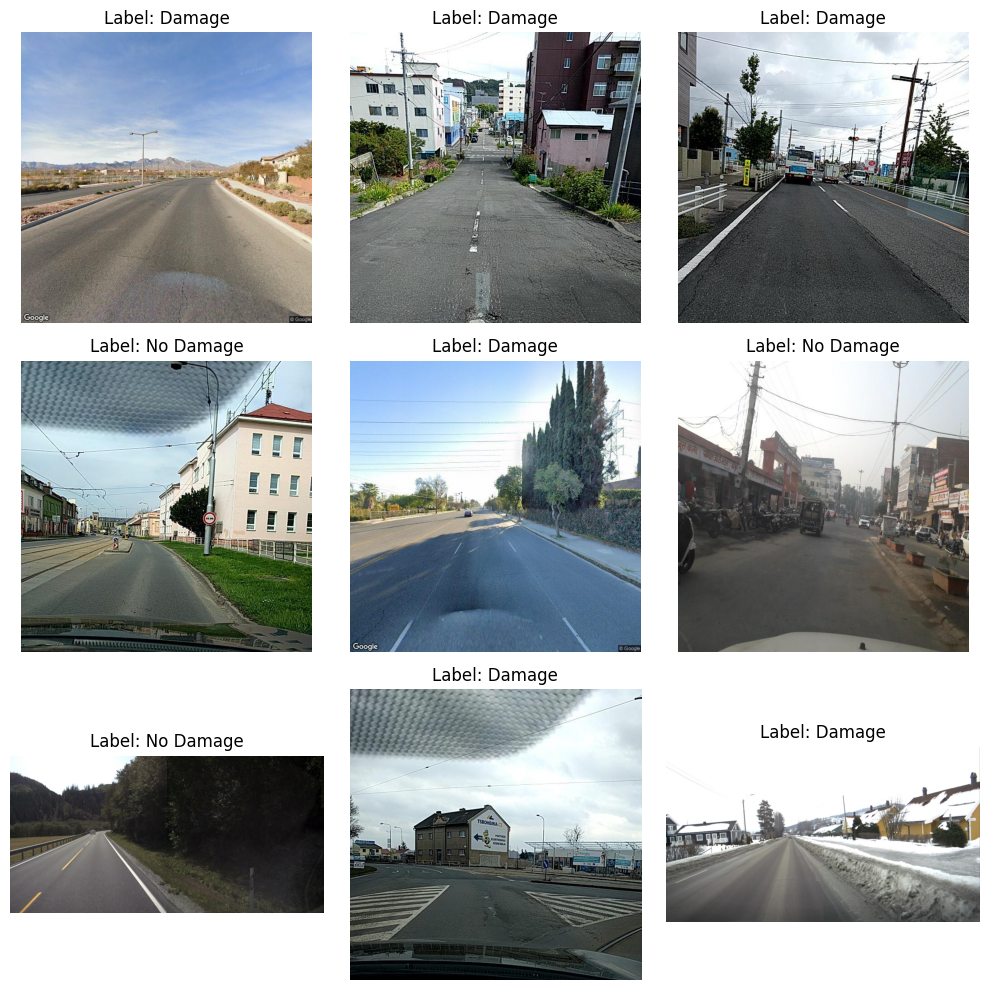

In [12]:


num_pictures_to_plot = 9
if len(df_cleaned) >= num_pictures_to_plot:
    random_sample = df_cleaned.sample(num_pictures_to_plot, random_state=42, replace=False)

    plt.figure(figsize=(10, 10))
    for i, (index, row) in enumerate(random_sample.iterrows()):
        img_path = row['image_path']
        label = row['label']
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(3, 3, i + 1)
                plt.imshow(img)
                plt.title(f"Label: {'Damage' if label == 1 else 'No Damage'}")
                plt.axis('off')
            else:
                 print(f"Warning: Could not load image {img_path} for plotting.")
                 plt.subplot(3, 3, i + 1)
                 plt.text(0.5, 0.5, 'Load Error', horizontalalignment='center', verticalalignment='center')
                 plt.title(f"Label: {'Damage' if label == 1 else 'No Damage'}")
                 plt.axis('off')

        except Exception as e:
            print(f"Could not process or plot image {img_path}: {e}")
            plt.subplot(3, 3, i + 1)
            plt.text(0.5, 0.5, 'Processing Error', horizontalalignment='center', verticalalignment='center')
            plt.title(f"Label: {'Damage' if label == 1 else 'No Damage'}")
            plt.axis('off')


    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough images ({len(df_cleaned)}) to plot {num_pictures_to_plot}.")

## Brightness, Blurriness,Colorfulnes

We check the imagies distributions based on the Brightness, Blurriness,Colorfulnes factors

In [13]:
def calculate_all_metrics_fixed_size(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    try:
        img_color = cv2.imread(image_path)
        if img_color is None:
            return None, None, None
        img_color_resized = cv2.resize(img_color, target_size, interpolation=cv2.INTER_AREA)
        

        #Brightness
        img_gray = cv2.cvtColor(img_color_resized, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(img_gray)

        #Blurriness
        blurriness = cv2.Laplacian(img_gray, cv2.CV_64F).var()

        #Colorfulnes
        img_color_float = img_color_resized.astype(np.float32) / 255.0

        B, G, R = cv2.split(img_color_float)

        rg = R - G
        yb = 0.5 * (R + G) - B

        std_rg = np.std(rg)
        std_yb = np.std(yb)
        mean_rg = np.mean(rg)
        mean_yb = np.mean(yb)

        colorfulness = np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)

        return brightness, blurriness, colorfulness

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None 

metrics_results = [calculate_all_metrics_fixed_size(p) for p in tqdm(df_cleaned['image_path'], desc="Calculating Metrics")]

if metrics_results:
    brightness_list, blurriness_list, colorfulness_list = zip(*metrics_results)

    df_cleaned['brightness'] = list(brightness_list)
    df_cleaned['blurriness'] = list(blurriness_list)
    df_cleaned['colorfulness'] = list(colorfulness_list)

initial_rows = len(df_cleaned)
df_cleaned.dropna(subset=['brightness', 'blurriness', 'colorfulness'], inplace=True)
rows_dropped = initial_rows - len(df_cleaned)

print(df_cleaned.shape)
print(df_cleaned.head())

Calculating Metrics: 100%|██████████| 33976/33976 [04:39<00:00, 121.71it/s]

(33976, 15)
  country      xml_filename          filename  \
0   Czech  Czech_000000.xml  Czech_000000.jpg   
1   Czech  Czech_000001.xml  Czech_000001.jpg   
2   Czech  Czech_000002.xml  Czech_000002.jpg   
3   Czech  Czech_000006.xml  Czech_000006.jpg   
4   Czech  Czech_000007.xml  Czech_000007.jpg   

                                 image_path  width  height  depth  \
0  data_final\Czech\images\Czech_000000.jpg    600     600    3.0   
1  data_final\Czech\images\Czech_000001.jpg    600     600    3.0   
2  data_final\Czech\images\Czech_000002.jpg    600     600    3.0   
3  data_final\Czech\images\Czech_000006.jpg    600     600    3.0   
4  data_final\Czech\images\Czech_000007.jpg    600     600    3.0   

   object_count  D40_object_count  has_damage  image_file_exists  label  \
0             0                 0       False               True      0   
1             0                 0       False               True      0   
2             0                 0       False        

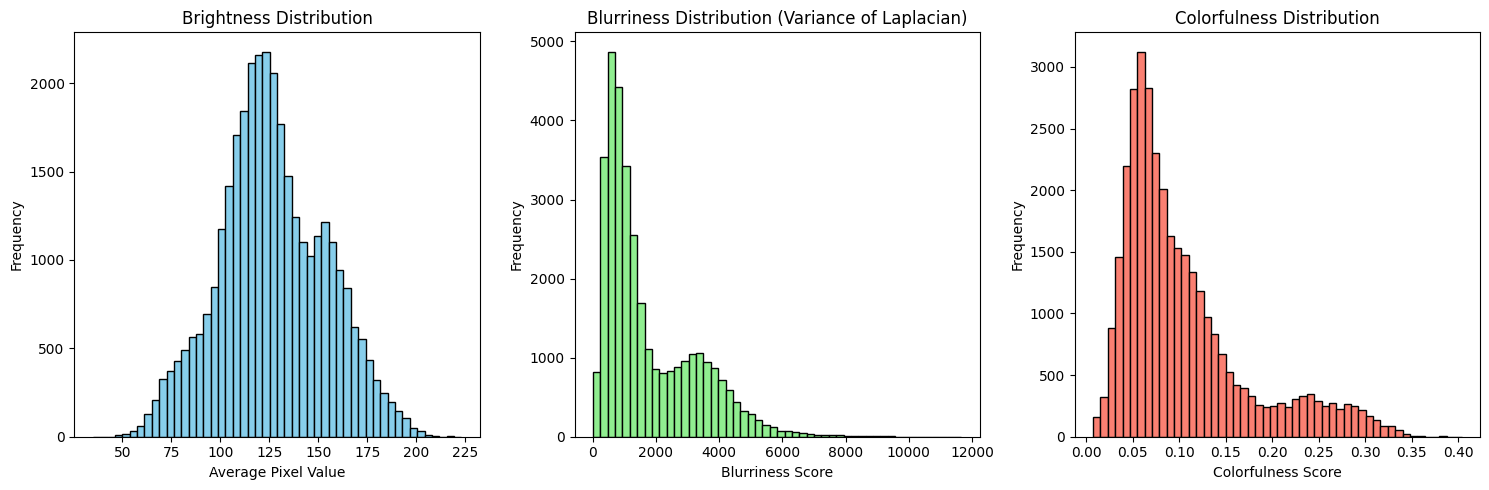

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_cleaned['brightness'], bins=50, color='skyblue', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_cleaned['blurriness'], bins=50, color='lightgreen', edgecolor='black', log=False)
plt.title('Blurriness Distribution (Variance of Laplacian)')
plt.xlabel('Blurriness Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_cleaned['colorfulness'].dropna(), bins=50, color='salmon', edgecolor='black')
plt.title('Colorfulness Distribution')
plt.xlabel('Colorfulness Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Delete Pictures Based on Blurriness

we delete the too blurry pictures

In [15]:
BLURRINESS_THRESHOLD = 300.0 

In [16]:


df_filtered_blur = df_cleaned[df_cleaned['blurriness'] >= BLURRINESS_THRESHOLD].copy()

print(f"Original image count: {len(df_cleaned)}")
print(f"Image count after removing blurry images: {len(df_filtered_blur)}")
print(f"Number of blurry images removed: {len(df_cleaned) - len(df_filtered_blur)}")

df_working = df_filtered_blur.copy()

Original image count: 33976
Image count after removing blurry images: 32453
Number of blurry images removed: 1523


# Dataset

we 70-30 split the dataset

In [17]:

image_paths_final = df_working['image_path'].values
labels_final = df_working['label'].values

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths_final, labels_final, test_size=0.3, random_state=42, stratify=labels_final
)

print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")

unique_train_labels, counts_train = np.unique(train_labels, return_counts=True)
unique_test_labels, counts_test = np.unique(test_labels, return_counts=True)



Training set size: 22717
Testing set size: 9736


In [18]:
print("Training labels distribution:")
for label, count in zip(unique_train_labels, counts_train):
    print(f"  Label {label}: {count} ({count/len(train_labels):.2%})")

print("Testing labels distribution:")
for label, count in zip(unique_test_labels, counts_test):
    print(f"  Label {label}: {count} ({count/len(test_labels):.2%})")


Training labels distribution:
  Label 0: 7615 (33.52%)
  Label 1: 15102 (66.48%)
Testing labels distribution:
  Label 0: 3264 (33.53%)
  Label 1: 6472 (66.47%)


# tf.data Pipelines

We use tensorflow.data api for loading the data to our models because it is more resource efficient.

In [19]:
#Based on Aurélien Géron's book Chapter: Chapter 13. Loading and Preprocessing Data with TensorFlow pdf page 563

def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=CHANNELS)
    img.set_shape([None, None, CHANNELS])
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.cast(label, tf.int32)

    return img, label

In [20]:
def augment_image(image, label):

    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image, label

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

In [22]:

train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))

train_dataset = train_dataset.batch(BATCH_SIZE)  #drop_remainder=True
test_dataset = test_dataset.batch(BATCH_SIZE) # drop_remainder=True)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Training dataset: {train_dataset}")
print(f"Testing dataset: {test_dataset}")

Training dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Testing dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Models

## SVM

Our base line support vector machine which is the first model we compareing to. It is highly unefficient on large amount of data

In [23]:
#Based on Aurélien Géron's book Chapter: Chapter 5. Support Vector Machines pdf page 246




X_train_list = []
y_train_list = []
for batch_images, batch_labels in tqdm(train_dataset, desc="Loading Training Data"):
    X_train_list.append(batch_images.numpy())
    y_train_list.append(batch_labels.numpy())

X_train_np = np.concatenate(X_train_list, axis=0)
y_train_np = np.concatenate(y_train_list, axis=0)
print(f"Training data loaded into NumPy. Shape: {X_train_np.shape}, Dtype: {X_train_np.dtype}")
del X_train_list, y_train_list


X_test_list = []
y_test_list = []
for batch_images, batch_labels in tqdm(test_dataset, desc="Loading Testing Data"):
    X_test_list.append(batch_images.numpy())
    y_test_list.append(batch_labels.numpy())

X_test_np = np.concatenate(X_test_list, axis=0)
y_test_np = np.concatenate(y_test_list, axis=0)

del X_test_list, y_test_list 

X_train_flat = X_train_np.reshape(X_train_np.shape[0], -1)
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)

print(f"Training data flattened shape: {X_train_flat.shape}")
print(f"Testing data flattened shape: {X_test_flat.shape}")

del X_train_np, X_test_np

print("\nApplying StandardScaler")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(f"Training data scaled shape: {X_train_scaled.shape}, Dtype: {X_train_scaled.dtype}")
print(f"Testing data scaled shape: {X_test_scaled.shape}, Dtype: {X_test_scaled.dtype}")

del X_train_flat, X_test_flat


print("\SVM model")

SVM_Model = SGDClassifier(
    loss='hinge',  #the specific loss function for SVM models      
    penalty='l2',          
    alpha=0.0001,          
    random_state=42,
    n_jobs=-1,           
    max_iter=1000 
)


start_time_model1 = time.time()

resource_usage_model1 = {'cpu_percent': [], 'ram_usage_mb': []}
record_cpu_ram_usage(resource_usage_model1)

print("Fitting the model")
SVM_Model.fit(X_train_scaled, y_train_np)
record_cpu_ram_usage(resource_usage_model1)

print("\nEvaluating the model")
y_pred_test_svm = SVM_Model.predict(X_test_scaled)



Loading Training Data: 100%|██████████| 355/355 [00:40<00:00,  8.72it/s]


Training data loaded into NumPy. Shape: (22717, 256, 256, 3), Dtype: float32


Loading Testing Data: 100%|██████████| 153/153 [00:10<00:00, 14.35it/s]


Training data flattened shape: (22717, 196608)
Testing data flattened shape: (9736, 196608)

Applying StandardScaler
Training data scaled shape: (22717, 196608), Dtype: float32
Testing data scaled shape: (9736, 196608), Dtype: float32
\SVM model
Attributes available on mem_info object:
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'nonpaged_pool', 'num_page_faults', 'paged_pool', 'pagefile', 'peak_nonpaged_pool', 'peak_paged_pool', 'peak_pagefile', 'peak_wset', 'private', 'rss', 'vms',

In [24]:
record_cpu_ram_usage(resource_usage_model1)


end_time_model1 = time.time()
runtime_model1 = end_time_model1 - start_time_model1

accuracy_svm_simple = accuracy_score(y_test_np, y_pred_test_svm)
print(f"\nTest Accuracy of SVM Model: {accuracy_svm_simple:.4f}")
print(classification_report(y_test_np, y_pred_test_svm, target_names=['No Damage', 'Damage']))

print("\nConfusion Matrix SVM:")
print(confusion_matrix(y_test_np, y_pred_test_svm))

print(f"\nRuntime (seconds): {runtime_model1:.2f}")
print(f"Maximum CPU Usage (%): {max(resource_usage_model1['cpu_percent']) if resource_usage_model1['cpu_percent'] else 'N/A'}")
print(f"Maximum RAM Usage (MB): {max(resource_usage_model1['ram_usage_mb']) if resource_usage_model1['ram_usage_mb'] else 'N/A'}")

Attributes available on mem_info object:
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'nonpaged_pool', 'num_page_faults', 'paged_pool', 'pagefile', 'peak_nonpaged_pool', 'peak_paged_pool', 'peak_pagefile', 'peak_wset', 'private', 'rss', 'vms', 'wset']
mem_info object: pmem(rss=7697035264, vms=28779483136, num_page_faults=379355948, peak_wset=31420170240, wset=7697035264, peak_paged_pool=6010632, paged_pool=5990424, peak_nonpaged_pool=1809120, nonpaged_pool=374096, pagefile=28779483136

In [25]:
#running garbage collection to free up the memory for running the next model
import gc
from tensorflow.keras import backend as K
print("\nClearing the model from memory...")
del SVM_Model


gc.collect()
K.clear_session()


Clearing the model from memory...


## Basic CNN

Second model, simple convolutional neural network for image classification

In [26]:
#based on Aurélien Géron's book Chapter: Chapter 17. Autoencoders, GANs, and Diffusion Models: section Convolutional Autoencoders pdf page 809

def basic_cnn(input_shape):

    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    return model

input_shape_cnn = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
basic_cnn_model = basic_cnn(input_shape_cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [27]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

resource_usage_model2 = {
    'cpu_percent': [],
    'ram_usage_mb': [],
    'gpu_memory_mb': []
}
start_time_model2 = time.time()

def record_cnn(resource_dict):
    cpu, ram = get_cpu_ram_usage()
    gpu_mem = get_gpu_memory_usage()
    resource_dict['cpu_percent'].append(cpu)
    resource_dict['ram_usage_mb'].append(ram)
    resource_dict['gpu_memory_mb'].append(gpu_mem)

record_cnn(resource_usage_model2)

CNN_EPOCHS = 15 
history_cnn_simple = basic_cnn_model.fit(
    train_dataset,
    epochs=CNN_EPOCHS,
    validation_data=test_dataset,
    verbose=1, 
    callbacks=[early_stopping_cnn]
)

end_time_model2 = time.time()
runtime_model2 = end_time_model2 - start_time_model2

record_cnn(resource_usage_model2)


Attributes available on mem_info object:
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'nonpaged_pool', 'num_page_faults', 'paged_pool', 'pagefile', 'peak_nonpaged_pool', 'peak_paged_pool', 'peak_pagefile', 'peak_wset', 'private', 'rss', 'vms', 'wset']
mem_info object: pmem(rss=7954685952, vms=29036158976, num_page_faults=379420747, peak_wset=31420170240, wset=7954685952, peak_paged_pool=6010632, paged_pool=5998296, peak_nonpaged_pool=1809120, nonpaged_pool=373416, pagefile=29036158976

In [28]:
loss_cnn, accuracy_cnn = basic_cnn_model.evaluate(test_dataset, verbose=0)

print(f"Test Loss (Basic CNN): {loss_cnn:.4f}")
print(f"Test Accuracy (Basic CNN): {accuracy_cnn:.4f}")

y_pred_probs_cnn = basic_cnn_model.predict(test_dataset)
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int)

y_true_test_cnn = test_labels

print(classification_report(y_true_test_cnn, y_pred_cnn, target_names=['No Damage', 'Damage']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true_test_cnn, y_pred_cnn))

print(f"Runtime (seconds): {runtime_model2:.2f}")
print(f"Maximum CPU Usage (%): {max(resource_usage_model2['cpu_percent']) if resource_usage_model2['cpu_percent'] else 'N/A'}")
print(f"Maximum RAM Usage (MB): {max(resource_usage_model2['ram_usage_mb']) if resource_usage_model2['ram_usage_mb'] else 'N/A'}")
print(f"Maximum GPU Memory Usage (MB): {max(resource_usage_model2['gpu_memory_mb']) if resource_usage_model2['gpu_memory_mb'] else 'N/A'}")
print(f"Test Accuracy: {accuracy_cnn:.4f}")

Test Loss (Basic CNN): 0.4106
Test Accuracy (Basic CNN): 0.7882
153/153 [==============================] - 11s 70ms/step
              precision    recall  f1-score   support

   No Damage       0.66      0.76      0.71      3264
      Damage       0.87      0.80      0.83      6472

    accuracy                           0.79      9736
   macro avg       0.76      0.78      0.77      9736
weighted avg       0.80      0.79      0.79      9736


Confusion Matrix:
[[2469  795]
 [1267 5205]]
Runtime (seconds): 678.39
Maximum CPU Usage (%): 21.4
Maximum RAM Usage (MB): 7901.45703125
Maximum GPU Memory Usage (MB): 193.14892578125
Test Accuracy: 0.7882


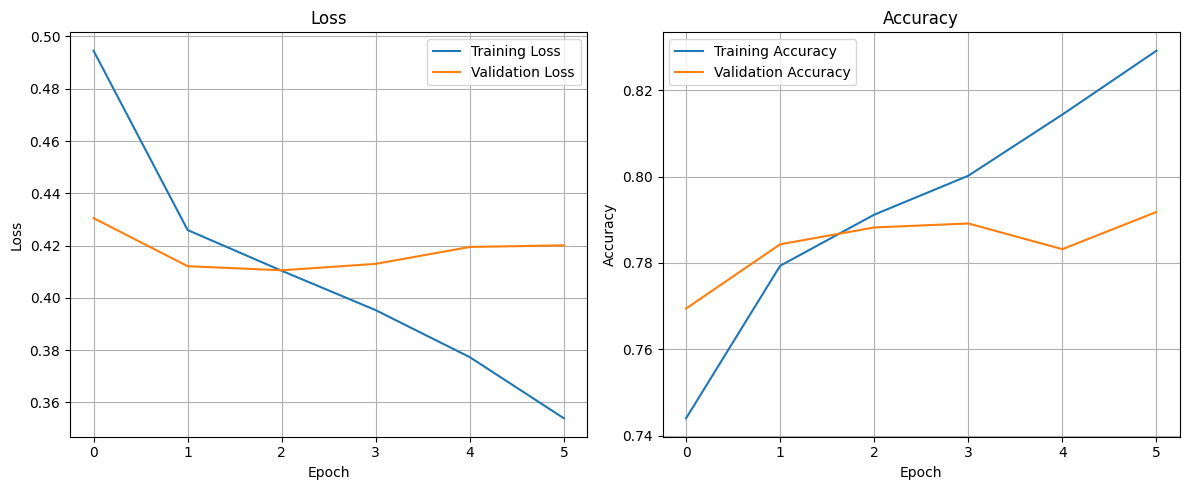

In [29]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) 
plt.plot(history_cnn_simple.history['loss'], label='Training Loss')
plt.plot(history_cnn_simple.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn_simple.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
import gc
from tensorflow.keras import backend as K
print("\nClearing Basic CNN Model")
del basic_cnn_model

gc.collect()
K.clear_session()


Clearing Basic CNN Model


## Autoencoder + CNN

third and final model which has two parts an autoencoder to reduce picture dimensionality, followed by a more complecx cnn model

### Autoencoder

In [31]:
#based on Aurélien Géron's book Chapter: Chapter 17. Autoencoders, GANs, and Diffusion Models: section Convolutional Autoencoders pdf page 809
def autoencoder(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    encoder_input = Input(shape=input_shape, name='encoder_input')

    #Encoder
    encoded = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(encoder_input)
    encoded = MaxPooling2D(pool_size=(2, 2))(encoded)
    encoded = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D(pool_size=(2, 2))(encoded)
    encoded = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(encoded)

    #Decoder
    decoder = Conv2DTranspose(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
    decoder = tf.image.resize(decoder, [IMG_HEIGHT // 4, IMG_WIDTH // 4])
    decoder = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
    decoder = tf.image.resize(decoder, [IMG_HEIGHT // 2, IMG_WIDTH // 2])
    decoder = Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
    decoder = tf.image.resize(decoder, [IMG_HEIGHT, IMG_WIDTH])
    decoder_output = Conv2D(filters=CHANNELS, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoder_output')(decoder)

    autoencoder_model = Model(inputs=encoder_input, outputs=decoder_output, name='autoencoder')
    autoencoder_model.compile(optimizer=Adam(), loss='mse')
    print("Convolutional Autoencoder model created")
    autoencoder_model.summary()
    return autoencoder_model

In [32]:
input_shape_autoencoder = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
autoencoder_model = autoencoder(input_shape_autoencoder)

train_dataset_ae = train_dataset.map(lambda image, label: (image, image))
test_dataset_ae = test_dataset.map(lambda image, label: (image, image))


print(f"Autoencoder Training dataset: {train_dataset_ae}")
print(f"Autoencoder Testing dataset: {test_dataset_ae}")

Convolutional Autoencoder model created
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv

In [33]:
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

resource_usage_ae = {
    'cpu_percent': [],
    'ram_usage_mb': [],
    'gpu_memory_mb': []
}
start_time_ae = time.time()

def record_cnn(resource_dict): #DELETE THIS FUNCTION in the final version
    cpu, ram = get_cpu_ram_usage()
    gpu_mem = get_gpu_memory_usage()
    resource_dict['cpu_percent'].append(cpu)
    resource_dict['ram_usage_mb'].append(ram)
    resource_dict['gpu_memory_mb'].append(gpu_mem)

record_cnn(resource_usage_ae)

AE_EPOCHS = 15 
history_ae = autoencoder_model.fit(
    train_dataset_ae,
    epochs=AE_EPOCHS,
    validation_data=test_dataset_ae,
    verbose=1, 
    callbacks=[early_stopping_ae]
)

end_time_ae = time.time()
runtime_ae = end_time_ae - start_time_ae

record_cnn(resource_usage_ae)


Attributes available on mem_info object:
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'nonpaged_pool', 'num_page_faults', 'paged_pool', 'pagefile', 'peak_nonpaged_pool', 'peak_paged_pool', 'peak_pagefile', 'peak_wset', 'private', 'rss', 'vms', 'wset']
mem_info object: pmem(rss=8474140672, vms=37277544448, num_page_faults=556498519, peak_wset=31420170240, wset=8474140672, peak_paged_pool=8107160, paged_pool=8092568, peak_nonpaged_pool=1809120, nonpaged_pool=441824, pagefile=37277544448

In [34]:
encoder_model = Model(inputs=autoencoder_model.input, outputs=autoencoder_model.get_layer(name='decoder_output').output, name='encoder') 

encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       7385

### Complex CNN

In [35]:
#Building the Complex CNN model architecture based on Aurélien Géron's book Page 447 (second edition) and page 635 (third edition)
encoder_output_shape = encoder_model.output_shape[1:] 

def complex_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(units=512, activation='relu'),
        Dropout(0.5),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=64, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

    model.summary()

    return model

complex_cnn_model = complex_cnn(encoder_output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 256)      0

In [36]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

resource_usage_cnn = {
    'cpu_percent': [],
    'ram_usage_mb': [],
    'gpu_memory_mb': []
}
start_time_cnn = time.time()

CNN_EPOCHS = 15 
history_cnn_complex = complex_cnn_model.fit(
    train_dataset,
    epochs=CNN_EPOCHS,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[early_stopping_cnn]
)

end_time_cnn = time.time()
runtime_cnn = end_time_cnn - start_time_cnn
record_cnn(resource_usage_cnn)

Epoch 1/15
355/355 [==============================] - 179s 325ms/step - loss: 0.5706 - accuracy: 0.6659 - val_loss: 0.4844 - val_accuracy: 0.7156
Epoch 2/15
355/355 [==============================] - 172s 314ms/step - loss: 0.4887 - accuracy: 0.7261 - val_loss: 0.4632 - val_accuracy: 0.7489
Epoch 3/15
355/355 [==============================] - 172s 313ms/step - loss: 0.4721 - accuracy: 0.7409 - val_loss: 0.4831 - val_accuracy: 0.7503
Epoch 4/15
355/355 [==============================] - 173s 312ms/step - loss: 0.4564 - accuracy: 0.7509 - val_loss: 0.4534 - val_accuracy: 0.7656
Epoch 5/15
355/355 [==============================] - 174s 312ms/step - loss: 0.4450 - accuracy: 0.7601 - val_loss: 0.4247 - val_accuracy: 0.7740
Epoch 6/15
355/355 [==============================] - 175s 312ms/step - loss: 0.4389 - accuracy: 0.7704 - val_loss: 0.4514 - val_accuracy: 0.7761
Epoch 7/15
355/355 [==============================] - 177s 315ms/step - loss: 0.4320 - accuracy: 0.7761 - val_loss: 0.4206 -

In [37]:
loss_cnn, accuracy_cnn = complex_cnn_model.evaluate(test_dataset, verbose=0)

print(f"Test Loss: {loss_cnn:.4f}")
print(f"Test Accuracy: {accuracy_cnn:.4f}")

y_pred_probs_cnn = complex_cnn_model.predict(test_dataset)
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int)
y_true_test_cnn = test_labels

print(classification_report(y_true_test_cnn, y_pred_cnn, target_names=['No Damage', 'Damage']))

print(confusion_matrix(y_true_test_cnn, y_pred_cnn))

print(f"\Autoencoder Training Runtime, in seconds: {runtime_cnn:.2f}")
print(f"Autoencoder Max CPU Usage (%): {max(resource_usage_ae['cpu_percent']) if resource_usage_ae['cpu_percent'] else 'N/A'}")
print(f"Autoencoder Max RAM Usage (MB): {max(resource_usage_ae['ram_usage_mb']) if resource_usage_ae['ram_usage_mb'] else 'N/A'}")
print(f"Autoencoder Max GPU Memory Usage (MB): {max(resource_usage_ae['gpu_memory_mb']) if resource_usage_ae['gpu_memory_mb'] else 'N/A'}")


print(f"\nComplex CNN Training Runtime (seconds): {runtime_cnn:.2f}")
print(f"Complex CNN Max CPU Usage (%): {max(resource_usage_cnn['cpu_percent']) if resource_usage_cnn['cpu_percent'] else 'N/A'}")
print(f"Complex CNN Max RAM Usage (MB): {max(resource_usage_cnn['ram_usage_mb']) if resource_usage_cnn['ram_usage_mb'] else 'N/A'}")
print(f"Complex CNN Max GPU Memory Usage (MB): {max(resource_usage_cnn['gpu_memory_mb']) if resource_usage_cnn['gpu_memory_mb'] else 'N/A'}")


Test Loss: 0.4086
Test Accuracy: 0.7865
153/153 [==============================] - 12s 78ms/step
              precision    recall  f1-score   support

   No Damage       0.71      0.61      0.66      3264
      Damage       0.82      0.88      0.85      6472

    accuracy                           0.79      9736
   macro avg       0.76      0.74      0.75      9736
weighted avg       0.78      0.79      0.78      9736

[[1989 1275]
 [ 804 5668]]
\Autoencoder Training Runtime, in seconds: 2300.53
Autoencoder Max CPU Usage (%): 61.1
Autoencoder Max RAM Usage (MB): 8081.5703125
Autoencoder Max GPU Memory Usage (MB): 197.36669921875

Complex CNN Training Runtime (seconds): 2300.53
Complex CNN Max CPU Usage (%): 28.6
Complex CNN Max RAM Usage (MB): 1137.4296875
Complex CNN Max GPU Memory Usage (MB): 986.19287109375


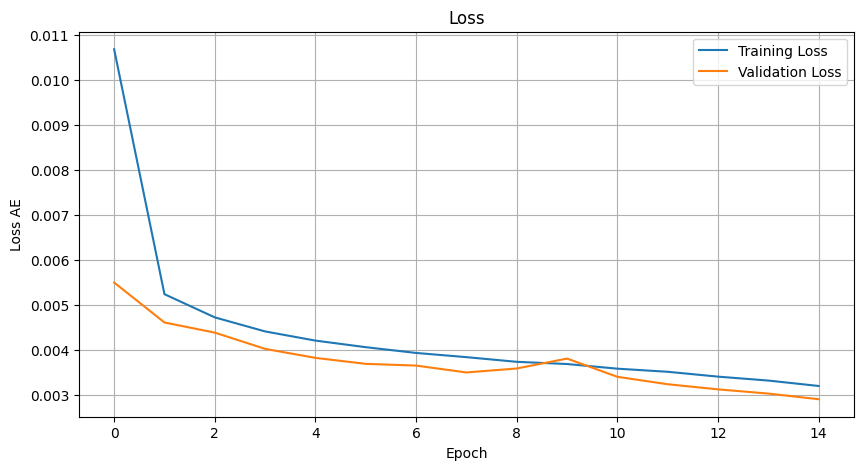

In [38]:

plt.figure(figsize=(10, 5))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss AE')
plt.legend()
plt.grid(True)
plt.show()

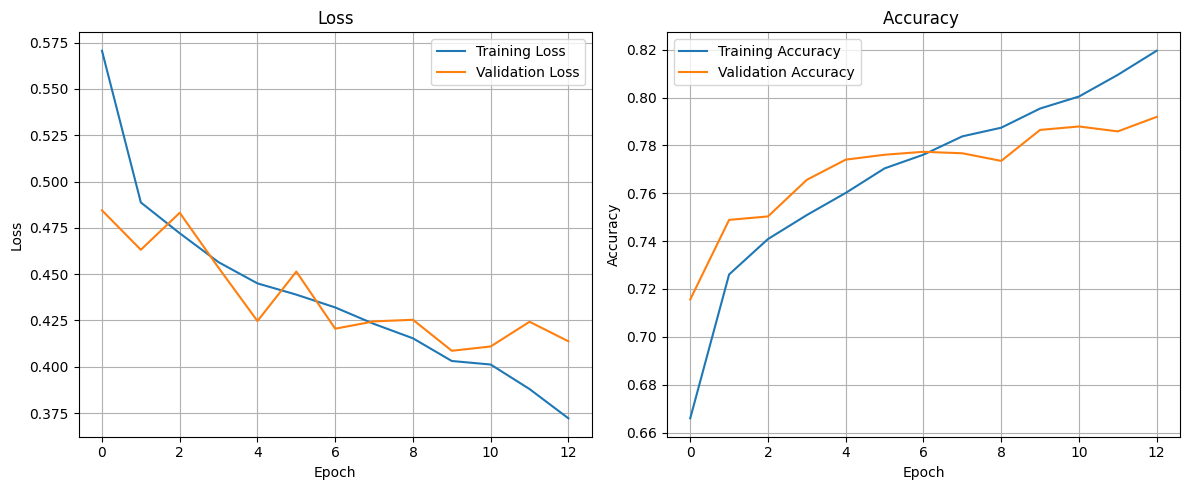

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) 
plt.plot(history_cnn_complex.history['loss'], label='Training Loss')
plt.plot(history_cnn_complex.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn_complex.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_complex.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()